In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import json
import time
from pandas.io.json import json_normalize

In [2]:
#Get data from Alpha Vantage using API request

url = "https://www.alphavantage.co/query"
params = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": "CL",
        "outputsize": "full",
        "apikey": "ac9ba10aa04a7d"}



response = requests.get(url, params=params)
data = response.json()

def df_from_response(data,
         columns=['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume']):

    def convert_response(d):
        # convert the response into datetimerecords that can be
        # parsed by Pandas
        for dt, prec in d['Time Series (Daily)'].items():
            r = { 'date': dt}
            r.update(prec)
            yield r
               
    # pass your response 'page'
    df = pd.DataFrame(convert_response(data))
    # rename the columns    
    df = df.rename(columns={'1. open': 'Open',
                            '2. high': 'High',
                            '3. low': 'Low',
                            '4. close': 'Close',
                            '5. adjusted close': 'AdjClose',
                            '6. volume': 'Volume'})
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    # extract the default columns
    df = df[columns]
    return df

df = df_from_response(data)
df.reset_index(level=0, inplace=True)
df.head()
# df = pd.DataFrame({'dates':pd.date_range('2018-01-01','2019-01-01')})
# newfd = df.columns = ['date' if x=='datetime' else x for x in df.columns]
# nf_h = pd.DataFrame(newfd)
# print('Data Frame:', nf_h)

,date,Open,High,Low,Close,AdjClose,Volume
0,1998-01-02,74.5000,74.5000,72.6900,73.2500,11.9706,451500
1,1998-01-05,74.0000,74.8800,73.2500,74.8800,12.2369,770000
2,1998-01-06,74.9400,74.9400,71.7500,71.9400,11.7565,861600
3,1998-01-07,70.2500,71.6300,69.8800,71.6300,11.7058,1125100
4,1998-01-08,71.6300,71.7500,69.3800,69.7500,11.3986,949700


In [3]:
#Convert results into a dataframe and assign an index
df1 = pd.DataFrame(df)
df1.reset_index(level=0, inplace=True)
df1.head()

,index,date,Open,High,Low,Close,AdjClose,Volume
0,0,1998-01-02,74.5000,74.5000,72.6900,73.2500,11.9706,451500
1,1,1998-01-05,74.0000,74.8800,73.2500,74.8800,12.2369,770000
2,2,1998-01-06,74.9400,74.9400,71.7500,71.9400,11.7565,861600
3,3,1998-01-07,70.2500,71.6300,69.8800,71.6300,11.7058,1125100
4,4,1998-01-08,71.6300,71.7500,69.3800,69.7500,11.3986,949700


In [4]:
# Select the date range we want to plot (this one will be for the year 2000)
df2 = df1[(df1['date'] > '2000-07-01') & (df1['date'] < '2000-09-30')]
df2.head()

,index,date,Open,High,Low,Close,AdjClose,Volume
630,630,2000-07-03,59.6300,60.0000,58.6300,59.8800,20.1801,864500
631,631,2000-07-05,59.0000,59.8100,58.8800,59.3100,19.9880,1610600
632,632,2000-07-06,59.8800,60.2500,58.7500,58.8100,19.8195,1355900
633,633,2000-07-07,57.5000,57.9400,56.8800,57.1900,19.2735,2124900
634,634,2000-07-10,57.2500,57.8800,55.5000,55.6900,18.7680,1475400


In [5]:
# Select the column of data needed for plotting
df2close = pd.DataFrame(df2[['date','Close']])
df2close.Close.dtype
df2close.Close = df2close.Close.astype(float)
df2close.head()

,date,Close
630,2000-07-03,59.88
631,2000-07-05,59.31
632,2000-07-06,58.81
633,2000-07-07,57.19
634,2000-07-10,55.69


In [11]:
# Use rolling method to plot moving averages
df2close['MA_1'] = df2close.Close.rolling(1).mean().shift()
df2close['MA_10'] = df2close.Close.rolling(10).mean().shift()
df2close.count()

date     63
Close    63
MA_1     62
MA_00    53
MA_10    53
dtype: int64

In [12]:
#Count of total rows in the new MA_1 colum
df2close['MA_1'].count()

62

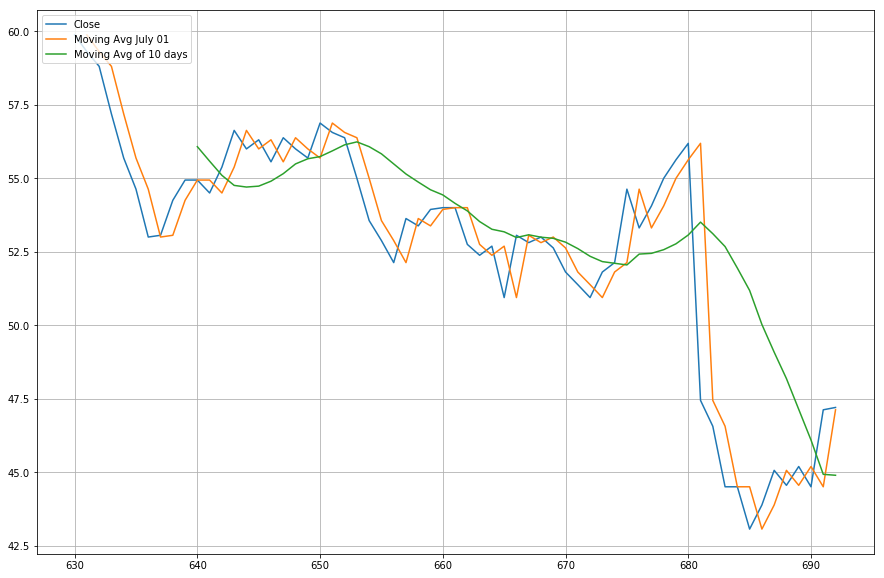

In [13]:
# Plot data and moving averages of 10 rolling standard deviation
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df2close['Close'],label='Close')
plt.plot(df2close['MA_1'], label='Moving Avg July 01')
plt.plot(df2close['MA_10'], label='Moving Avg of 10 days')
plt.legend(loc=2)

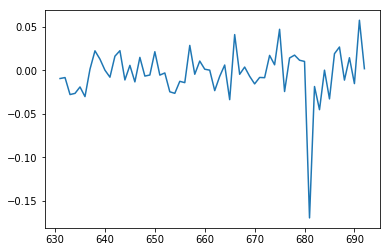

In [14]:
# Compute log change (instantaneous rate of return)
df2close["change"] = np.log(df2close["Close"] / df2close["Close"].shift())
plt.plot(df2close.change)

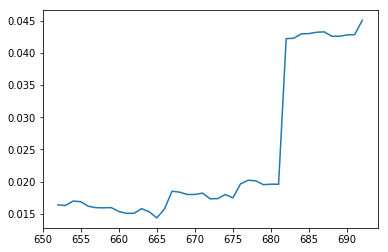

In [15]:
#  Compute rolling historical volatility, offset using .shift() method
df2close['Volatility'] = df2close.change.rolling(21).std().shift()
df2close['Volatility'].plot()

In [16]:
# price analysis
#offset expected change 1-day
df2close['exp_chng'] = df2close['Volatility'] * df2close['Close'].shift()
df2close['actual_chng'] = df2close['Close'] - df2close['Close'].shift()
#running more than once will 
df2close = pd.DataFrame(df2close.iloc[22:])
df2close['Magnitude'] = df2close['actual_chng'] / df2close['exp_chng'] 
df2close['abs_magni'] = np.abs(df2close['Magnitude'])
df2close.head()

,date,Close,MA_1,MA_00,MA_10,change,Volatility,exp_chng,actual_chng,Magnitude,abs_magni
652,2000-08-03,56.38,56.56,56.139,56.139,-0.003188,0.016370,0.925894,-0.18,-0.194407,0.194407
653,2000-08-04,55.00,56.38,56.239,56.239,-0.024781,0.016296,0.918752,-1.38,-1.502038,1.502038
654,2000-08-07,53.56,55.00,56.076,56.076,-0.026531,0.016974,0.933546,-1.44,-1.542505,1.542505
655,2000-08-08,52.88,53.56,55.832,55.832,-0.012777,0.016874,0.903762,-0.68,-0.752410,0.752410
656,2000-08-09,52.13,52.88,55.489,55.489,-0.014285,0.016169,0.854997,-0.75,-0.877196,0.877196


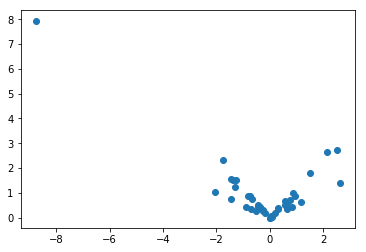

In [17]:
plt.scatter(df2close['actual_chng'], df2close['abs_magni'])